In [98]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [99]:
import os, sys

def get_dir_n_levels_up(path, n):
    # Go up n levels from the given path
    for _ in range(n):
        path = os.path.dirname(path)
    return path

proj_root = get_dir_n_levels_up(os.path.abspath("__file__"), 4)
sys.path.append(proj_root)

import warnings
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme()

warnings.filterwarnings("ignore")

from dqn.opinion_dynamics.utils.experiment import process_experiment


In [100]:
# experiment_sub_dir = "2025May02-101004_configs" # excellent run
# experiment_sub_dir = "2025Jul09-171538_configs" # good latest run
# experiment_sub_dir = "2025Sep15-090310_configs" paper run 1 finite h
experiment_sub_dir = "2025Oct06-004701_configs" 


exp_path = os.path.join(os.path.abspath("."), "results", experiment_sub_dir)
df = process_experiment(
    exp_path
)
# df.columns


In [101]:
# df

In [102]:
# df[df['epoch_type'] == 'validation']
# df[df['epoch_type'] == 'training']

In [103]:
# Define hyperparameter columns
hyperparam_columns = [col for col in df.columns if "sub_exp_cfg" in col]

# Group by hyperparameter values and compute mean episode_rewards_mean
averaged_results = df.groupby(hyperparam_columns, as_index=False).agg({
    'episode_rewards_mean': 'mean',  # Averaging the performance metric
    'sub_experiment_path': 'first'   # Keep a reference to an experiment path
})

# Find the best hyperparameter set based on the highest mean reward
best_row = averaged_results.loc[averaged_results['episode_rewards_mean'].idxmax()]

# Print the best experiment path and hyperparameters
print(f"Best hyperparameters:\n{best_row[hyperparam_columns]}")
print(f"Best mean reward: {best_row['episode_rewards_mean']}")

Best hyperparameters:
sub_exp_cfg_optim.args_.lr                                      1e-05
sub_exp_cfg_agent_params.args_.betas                        [0, 1, 2]
sub_exp_cfg_agent_params.model                     OpinionNetCommonAB
sub_exp_cfg_experiment                  opinion_agent_dqn_fixed_steps
Name: 0, dtype: object
Best mean reward: -45.38265956765249


In [104]:
averaged_results

,sub_exp_cfg_optim.args_.lr,sub_exp_cfg_agent_params.args_.betas,sub_exp_cfg_agent_params.model,sub_exp_cfg_experiment,episode_rewards_mean,sub_experiment_path
0,1e-05,"[0, 1, 2]",OpinionNetCommonAB,opinion_agent_dqn_fixed_steps,-45.38266,d:\Work\repos\RL\phd-rl-algos\dqn\opinion_dyna...
1,1e-06,"[0, 1, 2]",OpinionNetCommonAB,opinion_agent_dqn_fixed_steps,-46.54169,d:\Work\repos\RL\phd-rl-algos\dqn\opinion_dyna...


In [105]:
# selected_metric = 'episode_rewards_mean'
# hue_col = "sub_exp_cfg_agent_params.args_.action_w_noise_amplitude"

# # Filter for validation episodes
# validation_df = df[df['epoch_type'] == 'validation']

# # Get the unique sorted frame_stamp values
# unique_frames = np.sort(validation_df['frame_stamp'].unique())
# N = 1
# # Get all frame_stamp values after the first N unique ones
# filtered_frames = unique_frames[N:]

# # Filter the DataFrame to only include rows with these frame_stamp values
# filtered_df = validation_df[validation_df['frame_stamp'].isin(filtered_frames)]

# plt.figure(figsize=(10, 6))
# sns.lineplot(data=filtered_df, x='frame_stamp', y=selected_metric, hue=hue_col)
# plt.ylabel(selected_metric)
# plt.xlabel('Frame Stamp')
# plt.show()

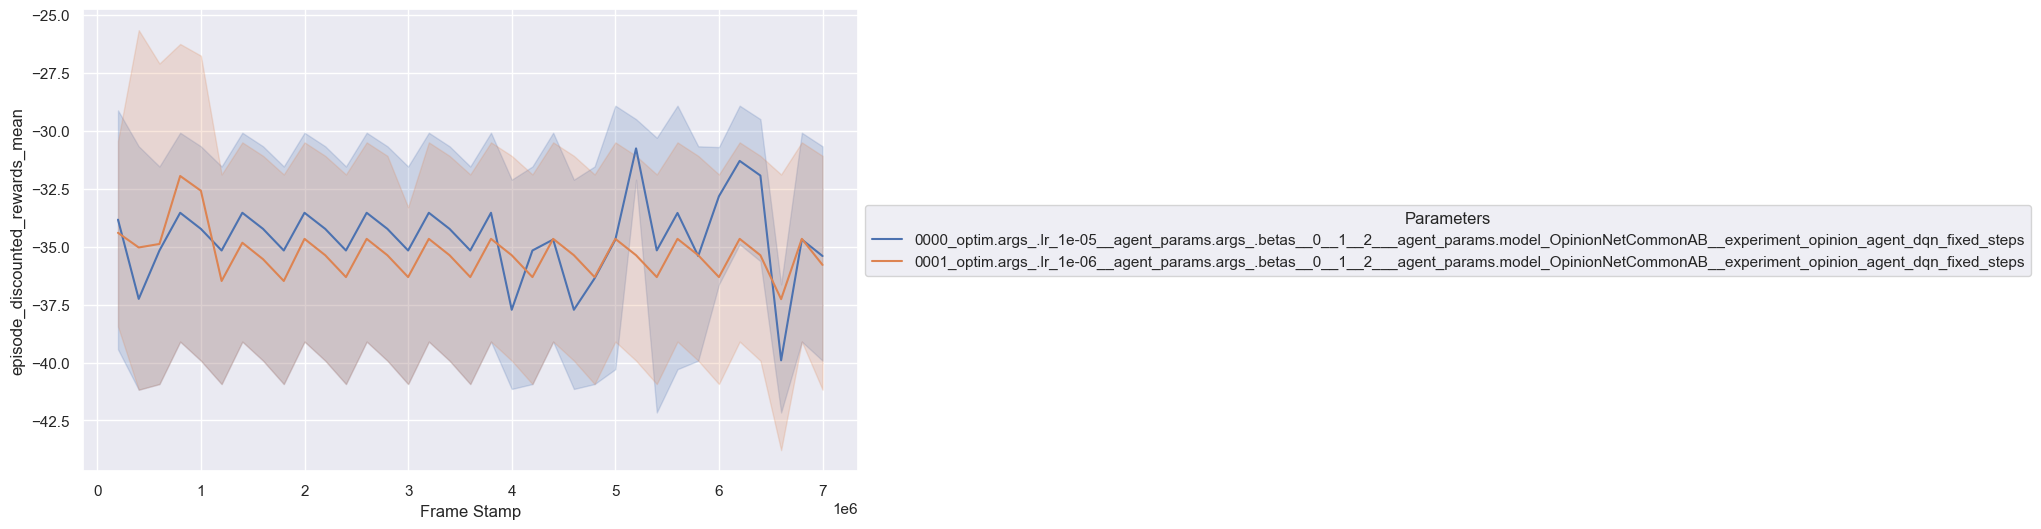

In [106]:

selected_metric = 'episode_discounted_rewards_mean'
# hue_col = "sub_exp_cfg_agent_params.args_.action_w_noise_amplitude"
hue_col = "experiment_name"

validation_df = df[df['epoch_type'] == 'validation']
# validation_df = df[df['epoch_type'] == 'training']


# Create a new figure for each environment
plt.figure(figsize=(10, 6))
# sns.lineplot(data=df, x='frame_stamp', y=selected_metric, hue='model')
sns.lineplot(data=validation_df, 
             x='frame_stamp', 
             y=selected_metric, 
             hue=hue_col,
            #  units='seed', # Comment this to see mean + cf
            #  estimator=None, # Comment this to see mean + cf
             )

plt.ylabel(selected_metric)
plt.xlabel('Frame Stamp')

# Place the legend outside the plot
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), title='Parameters')
plt.show()

In [107]:
df.columns

Index(['epoch_type', 'frame_stamp', 'greedy_epsilon', 'episode_rewards_min',
       'episode_rewards_max', 'episode_rewards_mean', 'episode_rewards_median',
       'episode_rewards_std', 'episode_discounted_rewards_min',
       'episode_discounted_rewards_max', 'episode_discounted_rewards_mean',
       'episode_discounted_rewards_median', 'episode_discounted_rewards_std',
       'episode_frames_min', 'episode_frames_max', 'episode_frames_mean',
       'episode_frames_median', 'episode_frames_std', 'episode_losses_min',
       'episode_losses_max', 'episode_losses_mean', 'episode_losses_median',
       'episode_losses_std', 'episode_max_qs_min', 'episode_max_qs_max',
       'episode_max_qs_mean', 'episode_max_qs_median', 'episode_max_qs_std',
       'policy_trained_times', 'target_trained_times', 'epoch_time',
       'sub_exp_cfg_optim.args_.lr', 'sub_exp_cfg_agent_params.args_.betas',
       'sub_exp_cfg_agent_params.model', 'sub_exp_cfg_experiment',
       'sub_experiment_path', 'seed

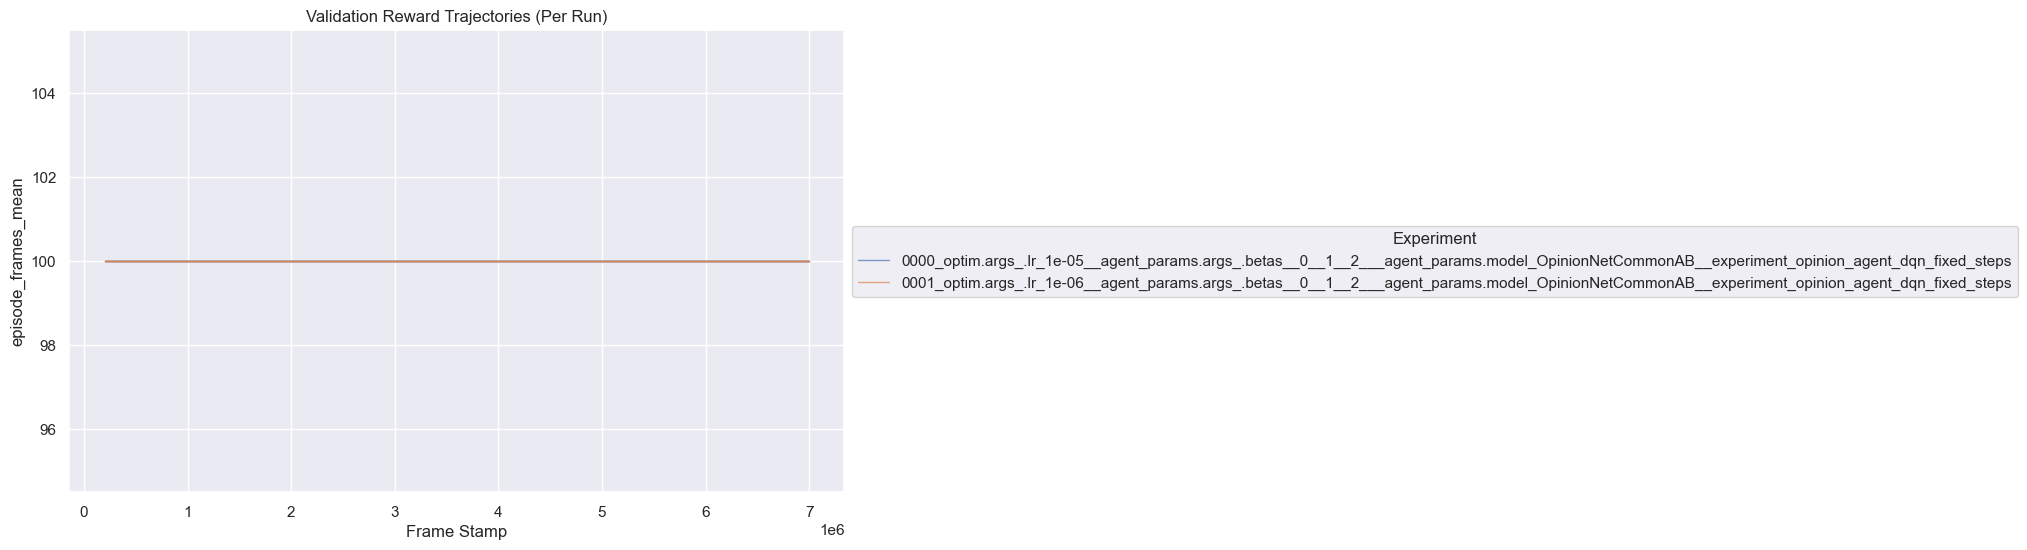

In [108]:
import matplotlib.pyplot as plt
import seaborn as sns

selected_metric = 'episode_frames_mean'
hue_col = "experiment_name"  # or another distinguishing column like "sub_experiment_path"

validation_df = df[df['epoch_type'] == 'validation']

# Plot individual lines for each run
plt.figure(figsize=(10, 6))
sns.lineplot(
    data=validation_df,
    x='frame_stamp',
    y=selected_metric,
    hue=hue_col,
    estimator=None,  # ← disables aggregation
    units='sub_experiment_path',  # ← groups lines by unique run
    lw=1,  # line width
    alpha=0.7  # transparency
)

plt.ylabel(selected_metric)
plt.xlabel('Frame Stamp')
plt.title('Validation Reward Trajectories (Per Run)')

# Move legend outside the plot
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), title='Experiment')
plt.tight_layout()
plt.show()


In [109]:
### Select data

experiment_columns = [
    'epoch_type', 'frame_stamp',
    'episode_rewards_mean', 'episode_frames_mean', 
    'episode_discounted_rewards_mean',
    'policy_trained_times', 'target_trained_times', 'epoch_time', 
       'seed', 'experiment_name', "sub_experiment_path"
]
hyperparam_columns = [
   col for col in df.columns if "sub_exp_cfg" in col
]

cols_of_interest = experiment_columns + hyperparam_columns

sub_df = df[cols_of_interest]
sub_df = sub_df[sub_df['epoch_type'] == 'validation']
sub_df = sub_df[sub_df['frame_stamp'] == sub_df['frame_stamp'].max()]

sub_df 


,epoch_type,frame_stamp,episode_rewards_mean,episode_frames_mean,episode_discounted_rewards_mean,policy_trained_times,target_trained_times,epoch_time,seed,experiment_name,sub_experiment_path,sub_exp_cfg_optim.args_.lr,sub_exp_cfg_agent_params.args_.betas,sub_exp_cfg_agent_params.model,sub_exp_cfg_experiment
69,validation,7000000,-62.315798,100.0,-39.919575,NaN,NaN,0 days 00:00:01.932964,0,0000_optim.args_.lr_1e-05__agent_params.args_....,d:\Work\repos\RL\phd-rl-algos\dqn\opinion_dyna...,1e-05,"[0, 1, 2]",OpinionNetCommonAB,opinion_agent_dqn_fixed_steps
139,validation,7000000,-54.036258,100.0,-35.622289,NaN,NaN,0 days 00:00:01.570602,1,0000_optim.args_.lr_1e-05__agent_params.args_....,d:\Work\repos\RL\phd-rl-algos\dqn\opinion_dyna...,1e-05,"[0, 1, 2]",OpinionNetCommonAB,opinion_agent_dqn_fixed_steps
209,validation,7000000,-45.221938,100.0,-30.663503,NaN,NaN,0 days 00:00:01.658167,2,0000_optim.args_.lr_1e-05__agent_params.args_....,d:\Work\repos\RL\phd-rl-algos\dqn\opinion_dyna...,1e-05,"[0, 1, 2]",OpinionNetCommonAB,opinion_agent_dqn_fixed_steps
279,validation,7000000,-65.045683,100.0,-41.173829,NaN,NaN,0 days 00:00:01.542791,0,0001_optim.args_.lr_1e-06__agent_params.args_....,d:\Work\repos\RL\phd-rl-algos\dqn\opinion_dyna...,1e-06,"[0, 1, 2]",OpinionNetCommonAB,opinion_agent_dqn_fixed_steps
349,validation,7000000,-53.006145,100.0,-35.105964,NaN,NaN,0 days 00:00:01.565375,1,0001_optim.args_.lr_1e-06__agent_params.args_....,d:\Work\repos\RL\phd-rl-algos\dqn\opinion_dyna...,1e-06,"[0, 1, 2]",OpinionNetCommonAB,opinion_agent_dqn_fixed_steps
419,validation,7000000,-45.391293,100.0,-31.075866,NaN,NaN,0 days 00:00:01.517498,2,0001_optim.args_.lr_1e-06__agent_params.args_....,d:\Work\repos\RL\phd-rl-algos\dqn\opinion_dyna...,1e-06,"[0, 1, 2]",OpinionNetCommonAB,opinion_agent_dqn_fixed_steps


In [110]:
agg_cols = [col for col in sub_df.columns if "sub_exp_cfg" in col]
aggregated_df = (
    sub_df.groupby(agg_cols)
    .agg(episode_discounted_rewards_mean=("episode_discounted_rewards_mean", "mean"))
    .reset_index()
)
aggregated_df

,sub_exp_cfg_optim.args_.lr,sub_exp_cfg_agent_params.args_.betas,sub_exp_cfg_agent_params.model,sub_exp_cfg_experiment,episode_discounted_rewards_mean
0,1e-05,"[0, 1, 2]",OpinionNetCommonAB,opinion_agent_dqn_fixed_steps,-35.401789
1,1e-06,"[0, 1, 2]",OpinionNetCommonAB,opinion_agent_dqn_fixed_steps,-35.785220


In [111]:
sub_df.columns

Index(['epoch_type', 'frame_stamp', 'episode_rewards_mean',
       'episode_frames_mean', 'episode_discounted_rewards_mean',
       'policy_trained_times', 'target_trained_times', 'epoch_time', 'seed',
       'experiment_name', 'sub_experiment_path', 'sub_exp_cfg_optim.args_.lr',
       'sub_exp_cfg_agent_params.args_.betas',
       'sub_exp_cfg_agent_params.model', 'sub_exp_cfg_experiment'],
      dtype='object')

In [112]:
print(sub_df[sub_df['episode_rewards_mean'] == sub_df['episode_rewards_mean'].max()]['sub_experiment_path'].values[0])


d:\Work\repos\RL\phd-rl-algos\dqn\opinion_dynamics\experiments\results\2025Oct06-004701_configs\0000_optim.args_.lr_1e-05__agent_params.args_.betas__0__1__2___agent_params.model_OpinionNetCommonAB__experiment_opinion_agent_dqn_fixed_steps\2


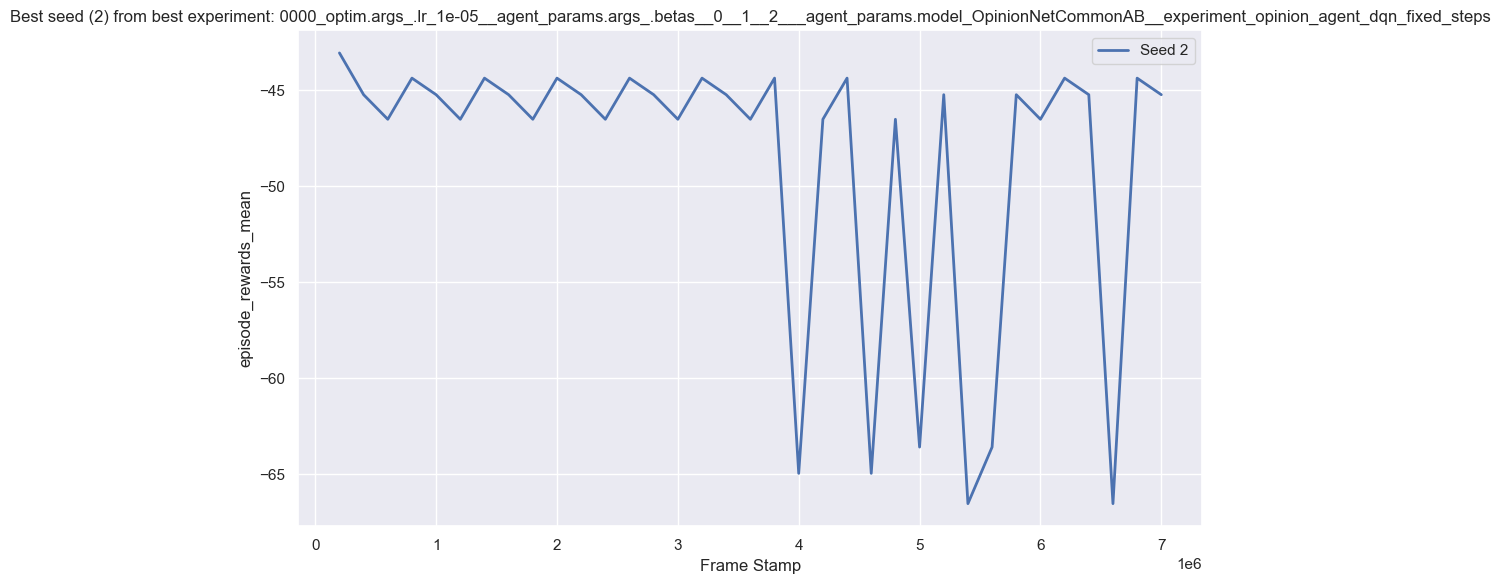

In [113]:
selected_metric = 'episode_rewards_mean'
hue_col = "experiment_name"

# Filter for training data only
# training_df = df[df['epoch_type'] == 'training']
training_df = df[df['epoch_type'] == 'validation']

# Step 1: Find best experiment
experiment_means = training_df.groupby(hue_col)[selected_metric].mean()
best_experiment = experiment_means.idxmax()

# Step 2: Filter to that experiment
best_exp_df = training_df[training_df[hue_col] == best_experiment]

# Step 3: Find best seed within best experiment
best_seed = (
    best_exp_df.groupby('seed')[selected_metric]
    .mean()
    .idxmax()
)

# Step 4: Filter to best seed
best_seed_df = best_exp_df[best_exp_df['seed'] == best_seed]

# Step 5: Plot
plt.figure(figsize=(10, 6))
sns.lineplot(
    data=best_seed_df,
    x='frame_stamp',
    y=selected_metric,
    lw=2,
    label=f"Seed {best_seed}"
)

plt.title(f"Best seed ({best_seed}) from best experiment: {best_experiment}")
plt.ylabel(selected_metric)
plt.xlabel('Frame Stamp')
plt.legend()
plt.tight_layout()
plt.show()

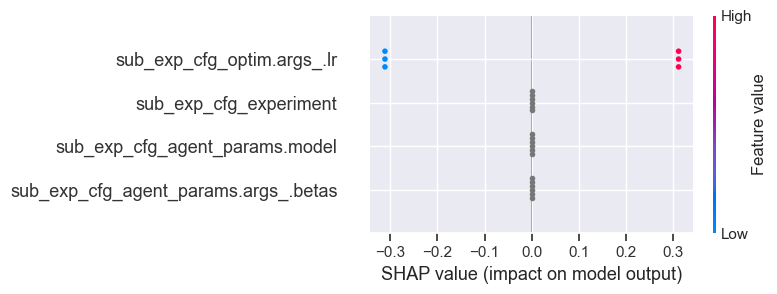

In [114]:
import shap
import xgboost
import pandas as pd


# Define the target metric and hyperparameter columns
target_metric = "episode_rewards_mean"  # Replace with actual metric column name
# Replace with actual hyperparameter column names

# Prepare data
X = sub_df[hyperparam_columns].apply(pd.to_numeric, errors='coerce')
y = sub_df[target_metric].fillna(3 * sub_df[target_metric].min())

# Train an XGBoost model to analyze feature importance
model = xgboost.XGBRegressor(objective="reg:squarederror", n_estimators=100, random_state=42)
model.fit(X, y)

# SHAP analysis
explainer = shap.Explainer(model)
shap_values = explainer(X)

# Summary plot (feature importance)
shap.summary_plot(shap_values, X)

In [115]:
hyperparam_columns

['sub_exp_cfg_optim.args_.lr',
 'sub_exp_cfg_agent_params.args_.betas',
 'sub_exp_cfg_agent_params.model',
 'sub_exp_cfg_experiment']

In [116]:
import plotly.express as px

# Define readable names for selected hyperparams
readable_names = {
    hyperparam_columns[0]: "noise",
    hyperparam_columns[1]: "size"
}

# Rename columns in a copy of the dataframe
plot_df = sub_df.rename(columns=readable_names)

# Assign new column names
x_col = "noise"
y_col = "episode_rewards_mean"
facet_col = "size"

# Plot
fig = px.scatter(
    plot_df,
    x=x_col,
    y=y_col,
    color="experiment_name",  # Optional: color by experiment
    facet_col=facet_col,
    title="Episode Rewards vs. Noise Faceted by Size",
    height=600
)

fig.update_layout(showlegend=False)
fig.show()
